In [46]:
from copy import deepcopy

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score

# Load data

Dataset is acquired from from Kaggle:
https://www.kaggle.com/prajitdatta/movielens-100k-dataset

## Interactions

In [2]:
interactions = pd.read_csv("data/ml-100k/u.data", sep="\t", header=None)
interactions.columns = ["user_id", "movie_id", "rating", "time"]

interactions["time"] = pd.to_datetime(interactions["time"],unit="s")

# Filter on ratings 3 or higher
interactions = interactions[interactions["rating"] >= 3]

interactions

,user_id,movie_id,rating,time
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
5,298,474,4,1998-01-07 14:20:06
7,253,465,5,1998-04-03 18:34:27
8,305,451,3,1998-02-01 09:20:17
...,...,...,...,...
99992,721,262,3,1997-10-18 01:14:45
99994,378,78,3,1997-11-20 20:16:16
99995,880,476,3,1997-11-22 05:10:44
99996,716,204,5,1997-11-17 19:39:03


## User features

In [3]:
user_features = pd.read_csv("data/ml-100k/u.user", sep="|", header=None)
user_features.columns = ["user_id", "age", "gender", "occupation", "zip_code"]

user_features

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


## Item features

In [4]:
item_features = pd.read_csv("data/ml-100k/u.item", sep="|", header=None)
item_features.columns = [
    "movie_id", "movie_title", "release_date", "video_release_date",
    "IMDb_URL", "unknown", "Action", "Adventure", "Animation",
    "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
    "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
    "Thriller", "War", "Western",
]

movie_titles = item_features[["movie_id", "movie_title"]]

item_features["release_date"] = pd.to_datetime(item_features["release_date"])
item_features = item_features.drop(columns = ["movie_title", "video_release_date", "IMDb_URL", "unknown"])

In [5]:
item_features

,movie_id,release_date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995-01-01,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1995-01-01,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,1995-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,1995-01-01,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,1995-01-01,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,1998-02-06,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,1998-02-06,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,1998-01-01,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,1994-01-01,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# Feature engineering

LightFM is able to handle either all binary features or all continuous features.
In our data set there are a lot of categorical / binary features, so we will go with all binary features.

The following steps are done:
* Remove continuous features
* Remove zipcodes, that would be too granular feature
* Transform categorical into dummy variables

In [6]:
user_features = user_features.drop(columns=["age", "zip_code"])

In [7]:
user_features = user_features \
    .drop(columns=["gender", "occupation"]) \
    .join(
        pd.get_dummies(user_features[["gender", "occupation"]])
    )

In [8]:
user_features

,user_id,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
939,940,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
940,941,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
941,942,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
item_features = item_features.drop(columns=["release_date"])

In [10]:
item_features

,movie_id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# Split to current / new, train / validation sets

In this notebook we simulate the following scenario. We train the complete model at a certain point of time, we push this model to production.
But later on the users make new interactions and we also want to incorporate those to the model.

"Current" set will represent the interactions known at the time of training the complete model.
"New" set will represent the new interactions, that we also want to incorporate to the model.

## Interactions

### Split current, new on time

In [11]:
def get_split_time(interactions, current_ratio):
    split_time = interactions \
        .sort_values("time") \
        .reset_index() \
        .iloc[int(interactions.shape[0] * current_ratio)] \
        ["time"]
    return split_time

def current_new_split(interactions, current_ratio):
    split_time = get_split_time(interactions, current_ratio)

    interactions_current = interactions[interactions["time"] < split_time]
    interactions_new = interactions[interactions["time"] >= split_time]
    
    return interactions_current, interactions_new
    
interactions_current, interactions_new = current_new_split(interactions, 0.9)

In [12]:
interactions_current

,user_id,movie_id,rating,time
0,196,242,3,1997-12-04 15:55:49
5,298,474,4,1998-01-07 14:20:06
8,305,451,3,1998-02-01 09:20:17
9,6,86,3,1997-12-31 21:16:53
11,286,1014,5,1997-11-17 15:38:45
...,...,...,...,...
99992,721,262,3,1997-10-18 01:14:45
99994,378,78,3,1997-11-20 20:16:16
99995,880,476,3,1997-11-22 05:10:44
99996,716,204,5,1997-11-17 19:39:03


In [13]:
interactions_new

,user_id,movie_id,rating,time
1,186,302,3,1998-04-04 19:22:22
7,253,465,5,1998-04-03 18:34:27
21,167,486,4,1998-04-16 14:54:12
26,38,95,5,1998-04-13 01:14:54
69,223,274,4,1998-04-02 20:48:14
...,...,...,...,...
99921,659,657,5,1998-03-31 22:39:25
99942,363,181,5,1998-04-02 05:26:23
99953,655,913,4,1998-04-05 23:05:21
99988,421,498,4,1998-04-10 20:49:04


Let's have a look at how many new users and items are in the "new" set. New user / item means that they weren't present in the "current" set.

In [14]:
new_users = np.setdiff1d(interactions_new["user_id"], interactions_current["user_id"])
old_users = np.intersect1d(interactions_new["user_id"], interactions_current["user_id"])

print("Number of new users in new set: {}".format(len(new_users)))
print("Number of current users in new set: {}".format(len(old_users)))

Number of new users in new set: 76
Number of current users in new set: 86


In [15]:
new_items = np.setdiff1d(interactions_new["movie_id"], interactions_current["movie_id"])
old_items = np.intersect1d(interactions_new["movie_id"], interactions_current["movie_id"])

print("Number of new items in new set: {}".format(len(new_items)))
print("Number of current items in new set: {}".format(len(old_items)))

Number of new items in new set: 49
Number of current items in new set: 1167


Let's visualize the interactions in time, along with the split.

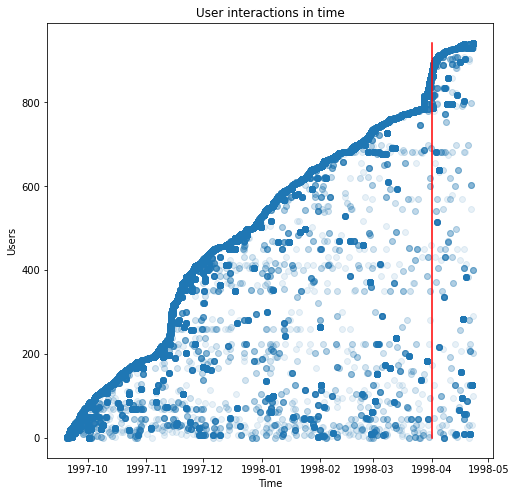

In [16]:
users_first_interactions = interactions \
    .groupby("user_id") \
    .agg({"time": "min"}) \
    .reset_index() \
    .rename(columns={"time": "first_time"})
users_first_interactions = users_first_interactions.sort_values("first_time")
users_first_interactions["first_rank"] = range(users_first_interactions.shape[0])

interactions_first_time = interactions.merge(users_first_interactions, on="user_id")

split_time = get_split_time(interactions, 0.9)
plt.figure(figsize=(8, 8))
plt.scatter(
    interactions_first_time["time"],
    interactions_first_time["first_rank"],
    alpha=0.1
)
plt.plot(
    [split_time, split_time],
    [interactions_first_time["first_rank"].min(), interactions_first_time["first_rank"].max()],
    color="red"
)
plt.title(
    "User interactions in time"
)
plt.xlabel("Time")
plt.ylabel("Users")
plt.show()

Users are ordered by their first interaction. Every dot represents an interaction, and the red line represents the 'current', 'new' split.

This explains why we see new users in the "new" data set.

### Split train, validation randomly

In [17]:
def train_test_split_randomly(data, test_size):
    """
    Randomly splits interactions to train and test.
    
    Makes sure there is at least 1 interaction for every user and item in the train set.
    """
    
    # Split randomly
    random_numbers = np.random.uniform(size=data.shape[0])
    test_mask = random_numbers <= test_size
    data_train = data[~test_mask]
    data_test = data[test_mask]
    
    # Make sure there is at least 1 interaction for every user and item in the train set
    for id_name in ["user_id", "movie_id"]:
        training_ids = data_train[id_name].unique()
        for id_ in data[id_name].unique():
            if id_ not in training_ids:
                row_to_training = data_test[data_test[id_name] == id_].sample(n=1)
                data_test = data_test.drop(index=row_to_training.index)
                data_train = data_train.append(row_to_training)
                
    return data_train, data_test


interactions_current_train, interactions_current_val = train_test_split_randomly(interactions_current, 0.3)

In [18]:
interactions_current_train

,user_id,movie_id,rating,time
0,196,242,3,1997-12-04 15:55:49
11,286,1014,5,1997-11-17 15:38:45
13,210,40,3,1998-03-27 21:59:54
14,224,29,3,1998-02-21 23:40:57
16,122,387,5,1997-11-11 17:47:39
...,...,...,...,...
96166,870,1664,4,1998-03-16 14:08:42
97122,877,1402,4,1997-12-21 04:09:46
98427,655,1637,3,1998-03-04 04:04:15
98640,655,1630,3,1998-02-14 03:58:55


In [19]:
interactions_current_val

,user_id,movie_id,rating,time
5,298,474,4,1998-01-07 14:20:06
8,305,451,3,1998-02-01 09:20:17
9,6,86,3,1997-12-31 21:16:53
12,200,222,5,1997-10-05 09:05:40
15,303,785,3,1997-11-14 05:28:38
...,...,...,...,...
99963,429,199,5,1997-12-17 19:13:26
99967,897,369,4,1997-11-20 02:41:53
99972,721,874,3,1997-10-18 01:17:27
99974,764,596,3,1997-10-07 16:50:46


## User, item features

In [20]:
user_features_current = user_features[user_features["user_id"].isin(interactions_current["user_id"])]
user_features_new = user_features[user_features["user_id"].isin(interactions_new["user_id"])]

print("Number of current users: {}".format(len(user_features_current)))
print("Number of new users: {}".format(len(user_features_new)))

Number of current users: 867
Number of new users: 162


In [21]:
item_features_current = item_features[item_features["movie_id"].isin(interactions_current["movie_id"])]
item_features_new = item_features[item_features["movie_id"].isin(interactions_new["movie_id"])]

print("Number of current items: {}".format(len(item_features_current)))
print("Number of new items: {}".format(len(item_features_new)))

Number of current items: 1525
Number of new items: 1216


# Transform to LightFM format

## Dataset

We intentionally initialize the dataset with more users / items that there are in the "current" data set.
The reason is that the model size can't be changed without retraining the complete model, but we want to be
able to incorporate interactions from potential new users / items. This way there is room for them.

In [22]:
print("Max user id: {}".format(interactions_current['user_id'].max()))
print("Max movie id: {}".format(interactions_current['movie_id'].max()))

Max user id: 943
Max movie id: 1682


In [23]:
user_ids_buffered = range(1000)
item_ids_buffered = range(1700)

user_feature_names = user_features.columns.tolist()
user_feature_names.remove("user_id")

item_feature_names = item_features.columns.tolist()
item_feature_names.remove("movie_id")

dataset = Dataset()
dataset.fit(
    users=user_ids_buffered,
    items=item_ids_buffered,
    user_features=user_feature_names,
    item_features=item_feature_names
)

## Interaction matrix

In [24]:
def transform_interactions(interactions):
    """
    Transforms interactions data frame to the format build_interactions needs it.
    
    Returns iterable of tuples (user_id, movie_id, weight).
    """
    return interactions[["user_id", "movie_id", "rating"]].itertuples(index=False)

In [25]:
interaction_matrix_current, _ = dataset.build_interactions(
    transform_interactions(interactions_current))

interaction_matrix_current_train, _ = dataset.build_interactions(
    transform_interactions(interactions_current_train))

interaction_matrix_current_val, _ = dataset.build_interactions(
    transform_interactions(interactions_current_val))

In [26]:
print(interaction_matrix_current.shape)
print(interaction_matrix_current_train.shape)
print(interaction_matrix_current_val.shape)

(1000, 1700)
(1000, 1700)
(1000, 1700)


## User, item features

In [27]:
def transform_features(features, id_name):
    """
    Transforms features data frame to the format build_user_features / build_item_features needs it.
    
    Returns iterable of (id, [list of feature names that has value 1]).
    """
    transformed_features = []
    for row in features.to_dict(orient="records"):
        id_value = row[id_name]
        del row[id_name]
        feature_names = [key for key, value in row.items() if value == 1]
        transformed_features.append(
            (id_value, feature_names)
        )
    return transformed_features

In [28]:
user_features_matrix_current = dataset.build_user_features(
    transform_features(user_features_current, "user_id"))

item_features_matrix_current = dataset.build_item_features(
    transform_features(item_features_current, "movie_id"))

# Train

## Model definition

In [29]:
model = LightFM(loss="warp")

## Training and hyperparameter tuning

In [30]:
class Evaluator():
    """
    Helper class for model evaluation
    
    Stores the number of epochs and corresponding performance metrics in a data frame.
    Returns the number of epochs with the best validation ROC AUC.
    Prepared to handle multiple runs of the same hyperparameters, and averages up the multiple runs.
    """
    
    def __init__(self):
        self.df_evaluation = pd.DataFrame()
    def evaluate(self, epochs, model, interaction_matrix_train, interaction_matrix_val, user_features_matrix, item_features_matrix):
            features_current = {
                "user_features": user_features_matrix,
                "item_features": item_features_matrix
            }
            evaluation_row = pd.DataFrame({
                "epochs": epochs,
                "train_precision": precision_at_k(model, interaction_matrix_train, k=10, **features_current).mean(),
                "validation_precision": precision_at_k(model, interaction_matrix_val, k=10, **features_current).mean(),
                "train_auc": auc_score(model, interaction_matrix_train, **features_current).mean(),
                "validation_auc": auc_score(model, interaction_matrix_val, **features_current).mean()
                },
                index=[0]
            )
            self.df_evaluation = self.df_evaluation.append(evaluation_row, ignore_index=True)
    def get_best_epochs(self):
        df_evaluation_agg = self.df_evaluation.groupby("epochs").agg("mean").reset_index()
        best_epochs =  df_evaluation_agg[
            df_evaluation_agg["validation_auc"] == df_evaluation_agg["validation_auc"].max()
        ]["epochs"].iloc[0]
        return best_epochs

In [31]:
evaluator = Evaluator()
for epochs in [100, 200, 300, 500, 1000, 2000]:
    print(f"Epochs: {epochs}")
    
    model.fit(
        interaction_matrix_current_train,
        epochs=epochs,
        user_features=user_features_matrix_current,
        item_features=item_features_matrix_current
    )
    
    evaluator.evaluate(
        epochs, model,
        interaction_matrix_current_train, interaction_matrix_current_val,
        user_features_matrix_current, item_features_matrix_current)

Epochs: 100
Epochs: 200
Epochs: 300
Epochs: 500
Epochs: 1000
Epochs: 2000


In [32]:
evaluator.df_evaluation

,epochs,train_precision,validation_precision,train_auc,validation_auc
0,100,0.413495,0.146420,0.907756,0.883156
1,200,0.457670,0.160277,0.926467,0.897800
2,300,0.497347,0.167090,0.938702,0.907911
3,500,0.514072,0.168129,0.946965,0.914250
4,1000,0.537716,0.167090,0.953773,0.918350
5,2000,0.544752,0.165473,0.958380,0.919866


## Retrain on complete training dataset

In [33]:
best_epochs = evaluator.get_best_epochs()
print(f"Best number of epochs: {best_epochs}")

model.fit(
    interaction_matrix_current,
    epochs=best_epochs,
    user_features=user_features_matrix_current,
    item_features=item_features_matrix_current
)

Best number of epochs: 2000


# Train and predict for new

## Create matrices

In [34]:
interaction_matrix_new, _ = dataset.build_interactions(
    transform_interactions(interactions_new))

user_features_matrix_new = dataset.build_user_features(
    transform_features(user_features_new, "user_id"))

item_features_matrix_new = dataset.build_item_features(
    transform_features(item_features_new, "movie_id"))

In [35]:
print(interaction_matrix_new.shape)
print(user_features_matrix_new.shape)
print(item_features_matrix_new.shape)

(1000, 1700)
(1000, 1023)
(1700, 1718)


In [36]:
user_features_matrix = dataset.build_user_features(
    transform_features(user_features, "user_id"))

item_features_matrix = dataset.build_item_features(
    transform_features(item_features, "movie_id"))

## Fit partial

Incorporate new interactions to the model. Since the number of new interactions can be small, for every hyperparameter set,
the train test split is done multiple times, and the performance is averaged up.

In [37]:
evaluator = Evaluator()
for epochs in [100, 500, 1000, 2000]:
    print(f"Epochs: {epochs}")

    num_fold = 5
    for fold in range(num_fold):
        print(f"fold: {fold}")
              
        interactions_new_train, interactions_new_val = train_test_split_randomly(interactions_new, 1/num_fold)
        interaction_matrix_new_train, _ = dataset.build_interactions(
            transform_interactions(interactions_new_train))
        interaction_matrix_new_val, _ = dataset.build_interactions(
            transform_interactions(interactions_new_val))
        
        model_fold = deepcopy(model)
        model_fold.fit_partial(
            interaction_matrix_new_train,
            user_features=user_features_matrix_new,
            item_features=item_features_matrix_new,
            epochs=epochs
        )

        evaluator.evaluate(
            epochs, model_fold,
            interaction_matrix_new_train, interaction_matrix_new_val,
            user_features_matrix_new, item_features_matrix_new)

Epochs: 100
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
Epochs: 500
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
Epochs: 1000
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
Epochs: 2000
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4


In [38]:
evaluator.df_evaluation.groupby("epochs").agg("mean").reset_index()

,epochs,train_precision,validation_precision,train_auc,validation_auc
0,100,0.299136,0.081650,0.892203,0.887516
1,500,0.345062,0.077575,0.921617,0.902536
2,1000,0.356543,0.076211,0.936391,0.904481
3,2000,0.381111,0.073123,0.952694,0.901498


In [39]:
best_epochs = evaluator.get_best_epochs()
print(f"Best number of epochs: {best_epochs}")

model.fit_partial(
    interaction_matrix_new,
    user_features=user_features_matrix_new,
    item_features=item_features_matrix_new,
    epochs=best_epochs
)

Best number of epochs: 1000


## Predict for a new sample user 

In [40]:
def predict(model, dataset, user_item_pairs, user_features_matrix, item_features_matrix):
    user_id_mapping, user_feature_mapping, item_id_mapping, item_feature_mapping = dataset.mapping()
    predictions = model.predict(
        user_ids=np.array([user_id_mapping[x] for x in user_item_pairs["user_id"]]),
        item_ids=np.array([item_id_mapping[x] for x in user_item_pairs["movie_id"]]),
        user_features=user_features_matrix,
        item_features=item_features_matrix
    )
    
    df_predictions = user_item_pairs.copy()
    df_predictions["prediction"] = predictions
    
    return df_predictions

def merge_interactions(df_evaluation, interactions):
    df_evaluation = df_evaluation.merge(interactions[["user_id", "movie_id", "rating"]], on=["user_id", "movie_id"], how="left")
    df_evaluation["has_interaction"] = ~df_evaluation["rating"].isna()
    df_evaluation = df_evaluation.drop(columns="rating")
    return df_evaluation

In [41]:
all_item_ids = np.unique(interactions["movie_id"])

user_sample_item_pairs = pd.DataFrame({
    "user_id": new_users[2],
    "movie_id": all_item_ids
})

predictions_sample = predict(model, dataset, user_sample_item_pairs, user_features_matrix, item_features_matrix)

predictions_sample = merge_interactions(predictions_sample, interactions)

In [42]:
# Condense item features into a compact list per item
item_features_no_id = item_features.drop(columns="movie_id")

item_features_list_series = item_features_no_id.apply(
    lambda row: [item_features_no_id.columns[i] for i, x in enumerate(row) if x == 1],
    axis=1)

item_features_list = pd.DataFrame({
    "movie_id": item_features["movie_id"],
    "feature_list": item_features_list_series,
})

In [43]:
predictions_sample = predictions_sample \
    .merge(movie_titles, on="movie_id") \
    .merge(item_features_list, on="movie_id")

predictions_sample = predictions_sample.sort_values("prediction", ascending=False)

In [44]:
# Movies that user rated
predictions_sample[predictions_sample["has_interaction"]]

,user_id,movie_id,prediction,has_interaction,movie_title,feature_list
99,27,100,-183.367188,True,Fargo (1996),"[Crime, Drama, Thriller]"
49,27,50,-183.502594,True,Star Wars (1977),"[Action, Adventure, Romance, Sci-Fi, War]"
287,27,288,-183.567810,True,Scream (1996),"[Horror, Thriller]"
8,27,9,-183.671555,True,Dead Man Walking (1995),[Drama]
120,27,121,-183.720093,True,Independence Day (ID4) (1996),"[Action, Sci-Fi, War]"
735,27,742,-183.813568,True,Ransom (1996),"[Drama, Thriller]"
502,27,508,-183.830414,True,"People vs. Larry Flynt, The (1996)",[Drama]
297,27,298,-184.066299,True,Face/Off (1997),"[Action, Sci-Fi, Thriller]"
285,27,286,-184.377060,True,"English Patient, The (1996)","[Drama, Romance, War]"
245,27,246,-184.455063,True,Chasing Amy (1997),"[Drama, Romance]"


In [45]:
# Top recommendations from the movies the user didn't watch
predictions_sample[~predictions_sample["has_interaction"]].head(20)

,user_id,movie_id,prediction,has_interaction,movie_title,feature_list
257,27,258,-182.961700,False,Contact (1997),"[Drama, Sci-Fi]"
6,27,7,-183.247574,False,Twelve Monkeys (1995),"[Drama, Sci-Fi]"
221,27,222,-183.349976,False,Star Trek: First Contact (1996),"[Action, Adventure, Sci-Fi]"
312,27,313,-183.489288,False,Titanic (1997),"[Action, Drama, Romance]"
236,27,237,-183.688583,False,Jerry Maguire (1996),"[Drama, Romance]"
116,27,117,-183.699783,False,"Rock, The (1996)","[Action, Adventure, Thriller]"
275,27,276,-183.765442,False,Leaving Las Vegas (1995),"[Drama, Romance]"
299,27,300,-183.785339,False,Air Force One (1997),"[Action, Thriller]"
256,27,257,-183.805420,False,Men in Black (1997),"[Action, Adventure, Comedy, Sci-Fi]"
281,27,282,-183.860794,False,"Time to Kill, A (1996)",[Drama]
